In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../')
from ARGUSUtils_Transforms import *

In [2]:
device_num = 1

img1_dir = "../../Data/Final15/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

num_classes = 3

net_dims = 2
net_in_channels = 4

num_workers_tr = 1
batch_size_tr = 16
num_workers_vl = 1
batch_size_vl = 4

num_slices = 32
size_x = 160
size_y = 320

model_filename_base = "./results/BAMC_PTX_ROINet-StdDevExtended-ExtrudedNS-Final15-Full-32s/"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns_image_60','218ns_image_63','219ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

Num images / labels = 47 47


In [3]:
train_files =  []
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in ns_prefix)],
        [se for se in all_labels if any(pref in se for pref in ns_prefix)])
    ])
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in s_prefix)],
        [se for se in all_labels if any(pref in se for pref in s_prefix)])
    ])
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in ns_prefix)],
        [se for se in all_labels if any(pref in se for pref in ns_prefix)])
    ])
train_files = list(np.concatenate(train_files).flat)
print(len(train_files))

62


../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/026ns_image_1083297968960_clean.nii.gz
../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/026ns_image_1083297968960_clean.extruded-overlay-NS.nii.gz


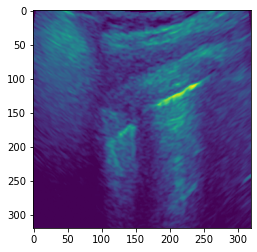

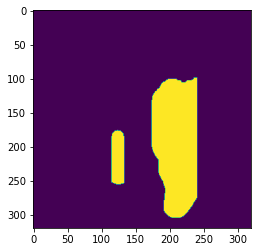

In [4]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[imgnum]["image"])
print(train_files[imgnum]["label"])

img = itk.imread(train_files[imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
train_loader = DataLoader(train_ds, batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr)

Loading dataset: 100%|██████████████████████████| 62/62 [00:08<00:00,  7.58it/s]


torch.Size([16, 4, 160, 320])
torch.Size([4, 160, 320])
image shape: torch.Size([4, 160, 320]), label shape: torch.Size([1, 160, 320])


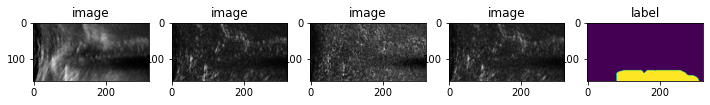

tensor(0.) tensor(1.)


In [7]:
imgnum = 2
check_data = first(train_loader)
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 5, 1)
plt.title("image")
plt.imshow(image[0, :, :], cmap="gray")
plt.subplot(1, 5, 2)
plt.title("image")
plt.imshow(image[1, :, :], cmap="gray")
plt.subplot(1, 5, 3)
plt.title("image")
plt.imshow(image[2, :, :], cmap="gray")
plt.subplot(1, 5, 4)
plt.title("image")
plt.imshow(image[3, :, :], cmap="gray")
plt.subplot(1, 5, 5)
plt.title("label")
plt.imshow(label[0, :, :])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))

max_epochs = 500
net_channels=(32, 64, 128)
net_strides=(2, 2)

In [9]:
def net_train(train_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"Epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in train_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2]+metric_values[-3])/3
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'best_model.pth')
                        print("saved new best metric model")
                if epoch == max_epochs // 3:
                    torch.save(model.state_dict(), model_filename_base+'Epoch'+str(epoch)+'_model.pth')
                if epoch == (2*max_epochs) // 3:
                    torch.save(model.state_dict(), model_filename_base+'Epoch'+str(epoch)+'_model.pth')
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'last_model.pth')

    np.save(model_filename_base+"loss.npy", epoch_loss_values)
    np.save(model_filename_base+"val_dice.npy", metric_values)

    

In [10]:
net_train(train_loader)

----------
Epoch 1/500
1/3, train_loss: 0.7413
2/3, train_loss: 0.7334
3/3, train_loss: 0.7260
4/3, train_loss: 0.7208
Epoch 1 average loss: 0.7304
----------
Epoch 2/500
1/3, train_loss: 0.7153
2/3, train_loss: 0.7067
3/3, train_loss: 0.7078
4/3, train_loss: 0.7104
Epoch 2 average loss: 0.7100
current epoch: 2 current mean dice: 0.3192
best mean dice: -1.0000 at epoch: -1
----------
Epoch 3/500
1/3, train_loss: 0.6958
2/3, train_loss: 0.7078
3/3, train_loss: 0.6924
4/3, train_loss: 0.7032
Epoch 3 average loss: 0.6998
----------
Epoch 4/500
1/3, train_loss: 0.6911
2/3, train_loss: 0.6948
3/3, train_loss: 0.6907
4/3, train_loss: 0.6783
Epoch 4 average loss: 0.6887
current epoch: 4 current mean dice: 0.2490
best mean dice: -1.0000 at epoch: -1
----------
Epoch 5/500
1/3, train_loss: 0.6920
2/3, train_loss: 0.6704
3/3, train_loss: 0.6749
4/3, train_loss: 0.6841
Epoch 5 average loss: 0.6804
----------
Epoch 6/500
1/3, train_loss: 0.6788
2/3, train_loss: 0.6784
3/3, train_loss: 0.6651
4/3, 

3/3, train_loss: 0.5627
4/3, train_loss: 0.6139
Epoch 44 average loss: 0.5791
current epoch: 44 current mean dice: 0.6454
best mean dice: -1.0000 at epoch: -1
----------
Epoch 45/500
1/3, train_loss: 0.5608
2/3, train_loss: 0.5887
3/3, train_loss: 0.5773
4/3, train_loss: 0.5557
Epoch 45 average loss: 0.5706
----------
Epoch 46/500
1/3, train_loss: 0.5704
2/3, train_loss: 0.5802
3/3, train_loss: 0.5829
4/3, train_loss: 0.5796
Epoch 46 average loss: 0.5783
current epoch: 46 current mean dice: 0.6445
best mean dice: -1.0000 at epoch: -1
----------
Epoch 47/500
1/3, train_loss: 0.5521
2/3, train_loss: 0.5917
3/3, train_loss: 0.5749
4/3, train_loss: 0.5911
Epoch 47 average loss: 0.5774
----------
Epoch 48/500
1/3, train_loss: 0.5666
2/3, train_loss: 0.5631
3/3, train_loss: 0.5830
4/3, train_loss: 0.5690
Epoch 48 average loss: 0.5704
current epoch: 48 current mean dice: 0.6642
best mean dice: -1.0000 at epoch: -1
----------
Epoch 49/500
1/3, train_loss: 0.5800
2/3, train_loss: 0.5661
3/3, tr

2/3, train_loss: 0.5522
3/3, train_loss: 0.5290
4/3, train_loss: 0.5428
Epoch 87 average loss: 0.5394
----------
Epoch 88/500
1/3, train_loss: 0.5200
2/3, train_loss: 0.5512
3/3, train_loss: 0.5356
4/3, train_loss: 0.5495
Epoch 88 average loss: 0.5391
current epoch: 88 current mean dice: 0.7102
best mean dice: -1.0000 at epoch: -1
----------
Epoch 89/500
1/3, train_loss: 0.5181
2/3, train_loss: 0.5356
3/3, train_loss: 0.5389
4/3, train_loss: 0.5470
Epoch 89 average loss: 0.5349
----------
Epoch 90/500
1/3, train_loss: 0.5500
2/3, train_loss: 0.5223
3/3, train_loss: 0.5320
4/3, train_loss: 0.5236
Epoch 90 average loss: 0.5320
current epoch: 90 current mean dice: 0.7005
best mean dice: -1.0000 at epoch: -1
----------
Epoch 91/500
1/3, train_loss: 0.5416
2/3, train_loss: 0.5297
3/3, train_loss: 0.5538
4/3, train_loss: 0.5198
Epoch 91 average loss: 0.5362
----------
Epoch 92/500
1/3, train_loss: 0.5532
2/3, train_loss: 0.5320
3/3, train_loss: 0.5125
4/3, train_loss: 0.5282
Epoch 92 average

4/3, train_loss: 0.5044
Epoch 129 average loss: 0.5076
----------
Epoch 130/500
1/3, train_loss: 0.5454
2/3, train_loss: 0.4998
3/3, train_loss: 0.5057
4/3, train_loss: 0.5257
Epoch 130 average loss: 0.5191
current epoch: 130 current mean dice: 0.7221
best mean dice: 0.7304 at epoch: 120
----------
Epoch 131/500
1/3, train_loss: 0.4983
2/3, train_loss: 0.5230
3/3, train_loss: 0.5006
4/3, train_loss: 0.5154
Epoch 131 average loss: 0.5093
----------
Epoch 132/500
1/3, train_loss: 0.5087
2/3, train_loss: 0.5195
3/3, train_loss: 0.5213
4/3, train_loss: 0.4934
Epoch 132 average loss: 0.5107
saved new best metric model
current epoch: 132 current mean dice: 0.7314
best mean dice: 0.7314 at epoch: 132
----------
Epoch 133/500
1/3, train_loss: 0.5359
2/3, train_loss: 0.5082
3/3, train_loss: 0.5151
4/3, train_loss: 0.4916
Epoch 133 average loss: 0.5127
----------
Epoch 134/500
1/3, train_loss: 0.5031
2/3, train_loss: 0.5253
3/3, train_loss: 0.5073
4/3, train_loss: 0.5016
Epoch 134 average loss: 

2/3, train_loss: 0.5206
3/3, train_loss: 0.4785
4/3, train_loss: 0.4946
Epoch 171 average loss: 0.4971
----------
Epoch 172/500
1/3, train_loss: 0.5050
2/3, train_loss: 0.5041
3/3, train_loss: 0.4883
4/3, train_loss: 0.5171
Epoch 172 average loss: 0.5036
current epoch: 172 current mean dice: 0.7409
best mean dice: 0.7545 at epoch: 162
----------
Epoch 173/500
1/3, train_loss: 0.5152
2/3, train_loss: 0.4963
3/3, train_loss: 0.4889
4/3, train_loss: 0.4828
Epoch 173 average loss: 0.4958
----------
Epoch 174/500
1/3, train_loss: 0.4661
2/3, train_loss: 0.5013
3/3, train_loss: 0.5017
4/3, train_loss: 0.5113
Epoch 174 average loss: 0.4951
current epoch: 174 current mean dice: 0.7400
best mean dice: 0.7545 at epoch: 162
----------
Epoch 175/500
1/3, train_loss: 0.5040
2/3, train_loss: 0.5014
3/3, train_loss: 0.4938
4/3, train_loss: 0.4912
Epoch 175 average loss: 0.4976
----------
Epoch 176/500
1/3, train_loss: 0.4657
2/3, train_loss: 0.4776
3/3, train_loss: 0.5175
4/3, train_loss: 0.5083
Epoc

1/3, train_loss: 0.5091
2/3, train_loss: 0.4817
3/3, train_loss: 0.4601
4/3, train_loss: 0.4781
Epoch 213 average loss: 0.4823
----------
Epoch 214/500
1/3, train_loss: 0.4877
2/3, train_loss: 0.4700
3/3, train_loss: 0.4712
4/3, train_loss: 0.4824
Epoch 214 average loss: 0.4778
current epoch: 214 current mean dice: 0.7548
best mean dice: 0.7768 at epoch: 212
----------
Epoch 215/500
1/3, train_loss: 0.5074
2/3, train_loss: 0.4916
3/3, train_loss: 0.4703
4/3, train_loss: 0.4728
Epoch 215 average loss: 0.4855
----------
Epoch 216/500
1/3, train_loss: 0.4740
2/3, train_loss: 0.4880
3/3, train_loss: 0.4677
4/3, train_loss: 0.4760
Epoch 216 average loss: 0.4765
current epoch: 216 current mean dice: 0.7463
best mean dice: 0.7768 at epoch: 212
----------
Epoch 217/500
1/3, train_loss: 0.4782
2/3, train_loss: 0.4814
3/3, train_loss: 0.4734
4/3, train_loss: 0.4669
Epoch 217 average loss: 0.4750
----------
Epoch 218/500
1/3, train_loss: 0.4598
2/3, train_loss: 0.4808
3/3, train_loss: 0.5031
4/3,

4/3, train_loss: 0.4762
Epoch 255 average loss: 0.4602
----------
Epoch 256/500
1/3, train_loss: 0.4774
2/3, train_loss: 0.4761
3/3, train_loss: 0.4612
4/3, train_loss: 0.4556
Epoch 256 average loss: 0.4676
current epoch: 256 current mean dice: 0.7740
best mean dice: 0.7831 at epoch: 246
----------
Epoch 257/500
1/3, train_loss: 0.4878
2/3, train_loss: 0.4767
3/3, train_loss: 0.4455
4/3, train_loss: 0.4548
Epoch 257 average loss: 0.4662
----------
Epoch 258/500
1/3, train_loss: 0.4566
2/3, train_loss: 0.4549
3/3, train_loss: 0.4681
4/3, train_loss: 0.4839
Epoch 258 average loss: 0.4659
current epoch: 258 current mean dice: 0.7775
best mean dice: 0.7831 at epoch: 246
----------
Epoch 259/500
1/3, train_loss: 0.4509
2/3, train_loss: 0.4836
3/3, train_loss: 0.4660
4/3, train_loss: 0.4533
Epoch 259 average loss: 0.4634
----------
Epoch 260/500
1/3, train_loss: 0.4590
2/3, train_loss: 0.4573
3/3, train_loss: 0.4741
4/3, train_loss: 0.4809
Epoch 260 average loss: 0.4678
current epoch: 260 cu

3/3, train_loss: 0.4470
4/3, train_loss: 0.4600
Epoch 297 average loss: 0.4562
----------
Epoch 298/500
1/3, train_loss: 0.4536
2/3, train_loss: 0.4490
3/3, train_loss: 0.4477
4/3, train_loss: 0.4699
Epoch 298 average loss: 0.4551
current epoch: 298 current mean dice: 0.8028
best mean dice: 0.8085 at epoch: 296
----------
Epoch 299/500
1/3, train_loss: 0.4349
2/3, train_loss: 0.4677
3/3, train_loss: 0.4595
4/3, train_loss: 0.4541
Epoch 299 average loss: 0.4541
----------
Epoch 300/500
1/3, train_loss: 0.4547
2/3, train_loss: 0.4516
3/3, train_loss: 0.4609
4/3, train_loss: 0.4517
Epoch 300 average loss: 0.4547
current epoch: 300 current mean dice: 0.7946
best mean dice: 0.8085 at epoch: 296
----------
Epoch 301/500
1/3, train_loss: 0.4375
2/3, train_loss: 0.4655
3/3, train_loss: 0.4575
4/3, train_loss: 0.4541
Epoch 301 average loss: 0.4537
----------
Epoch 302/500
1/3, train_loss: 0.4747
2/3, train_loss: 0.4349
3/3, train_loss: 0.4473
4/3, train_loss: 0.4465
Epoch 302 average loss: 0.45

1/3, train_loss: 0.4332
2/3, train_loss: 0.4498
3/3, train_loss: 0.4572
4/3, train_loss: 0.4424
Epoch 340 average loss: 0.4457
current epoch: 340 current mean dice: 0.7762
best mean dice: 0.8085 at epoch: 296
----------
Epoch 341/500
1/3, train_loss: 0.4516
2/3, train_loss: 0.4461
3/3, train_loss: 0.4727
4/3, train_loss: 0.4323
Epoch 341 average loss: 0.4506
----------
Epoch 342/500
1/3, train_loss: 0.4265
2/3, train_loss: 0.4513
3/3, train_loss: 0.4801
4/3, train_loss: 0.4436
Epoch 342 average loss: 0.4504
current epoch: 342 current mean dice: 0.7775
best mean dice: 0.8085 at epoch: 296
----------
Epoch 343/500
1/3, train_loss: 0.4502
2/3, train_loss: 0.4744
3/3, train_loss: 0.4481
4/3, train_loss: 0.4430
Epoch 343 average loss: 0.4539
----------
Epoch 344/500
1/3, train_loss: 0.4438
2/3, train_loss: 0.4609
3/3, train_loss: 0.4679
4/3, train_loss: 0.4405
Epoch 344 average loss: 0.4533
current epoch: 344 current mean dice: 0.7886
best mean dice: 0.8085 at epoch: 296
----------
Epoch 34

current epoch: 382 current mean dice: 0.7979
best mean dice: 0.8085 at epoch: 296
----------
Epoch 383/500
1/3, train_loss: 0.4376
2/3, train_loss: 0.4432
3/3, train_loss: 0.4465
4/3, train_loss: 0.4450
Epoch 383 average loss: 0.4431
----------
Epoch 384/500
1/3, train_loss: 0.4615
2/3, train_loss: 0.4488
3/3, train_loss: 0.4448
4/3, train_loss: 0.4383
Epoch 384 average loss: 0.4484
current epoch: 384 current mean dice: 0.7986
best mean dice: 0.8085 at epoch: 296
----------
Epoch 385/500
1/3, train_loss: 0.4460
2/3, train_loss: 0.4473
3/3, train_loss: 0.4401
4/3, train_loss: 0.4391
Epoch 385 average loss: 0.4431
----------
Epoch 386/500
1/3, train_loss: 0.4435
2/3, train_loss: 0.4395
3/3, train_loss: 0.4481
4/3, train_loss: 0.4482
Epoch 386 average loss: 0.4448
current epoch: 386 current mean dice: 0.7952
best mean dice: 0.8085 at epoch: 296
----------
Epoch 387/500
1/3, train_loss: 0.4281
2/3, train_loss: 0.4387
3/3, train_loss: 0.4476
4/3, train_loss: 0.4420
Epoch 387 average loss: 0

1/3, train_loss: 0.4324
2/3, train_loss: 0.4323
3/3, train_loss: 0.4458
4/3, train_loss: 0.4437
Epoch 425 average loss: 0.4385
----------
Epoch 426/500
1/3, train_loss: 0.4306
2/3, train_loss: 0.4383
3/3, train_loss: 0.4296
4/3, train_loss: 0.4514
Epoch 426 average loss: 0.4375
current epoch: 426 current mean dice: 0.8021
best mean dice: 0.8184 at epoch: 416
----------
Epoch 427/500
1/3, train_loss: 0.4513
2/3, train_loss: 0.4543
3/3, train_loss: 0.4241
4/3, train_loss: 0.4235
Epoch 427 average loss: 0.4383
----------
Epoch 428/500
1/3, train_loss: 0.4269
2/3, train_loss: 0.4493
3/3, train_loss: 0.4227
4/3, train_loss: 0.4462
Epoch 428 average loss: 0.4363
current epoch: 428 current mean dice: 0.8042
best mean dice: 0.8184 at epoch: 416
----------
Epoch 429/500
1/3, train_loss: 0.4235
2/3, train_loss: 0.4418
3/3, train_loss: 0.4331
4/3, train_loss: 0.4462
Epoch 429 average loss: 0.4362
----------
Epoch 430/500
1/3, train_loss: 0.4486
2/3, train_loss: 0.4509
3/3, train_loss: 0.4536
4/3,

4/3, train_loss: 0.4229
Epoch 467 average loss: 0.4301
----------
Epoch 468/500
1/3, train_loss: 0.4267
2/3, train_loss: 0.4327
3/3, train_loss: 0.4438
4/3, train_loss: 0.4344
Epoch 468 average loss: 0.4344
current epoch: 468 current mean dice: 0.8089
best mean dice: 0.8252 at epoch: 466
----------
Epoch 469/500
1/3, train_loss: 0.4214
2/3, train_loss: 0.4300
3/3, train_loss: 0.4172
4/3, train_loss: 0.4407
Epoch 469 average loss: 0.4273
----------
Epoch 470/500
1/3, train_loss: 0.4475
2/3, train_loss: 0.4182
3/3, train_loss: 0.4173
4/3, train_loss: 0.4353
Epoch 470 average loss: 0.4296
current epoch: 470 current mean dice: 0.8096
best mean dice: 0.8252 at epoch: 466
----------
Epoch 471/500
1/3, train_loss: 0.4299
2/3, train_loss: 0.4361
3/3, train_loss: 0.4321
4/3, train_loss: 0.4249
Epoch 471 average loss: 0.4308
----------
Epoch 472/500
1/3, train_loss: 0.4196
2/3, train_loss: 0.4233
3/3, train_loss: 0.4259
4/3, train_loss: 0.4303
Epoch 472 average loss: 0.4248
current epoch: 472 cu